In [96]:
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [6]:
ADD_TENANT_ID = '48d5043c-cf70-4c49-881c-c638f5796997'
ADD_CLIENT_ID = '1b90ede3-271e-401b-81a0-a4d52bea3273' #Azure regiserd app ip
project = 'publicdata'
CDF_CLUSTER = 'api'

In [7]:
from cognite.client import CogniteClient, ClientConfig
from cognite.client.credentials import OAuthInteractive

creds = OAuthInteractive(
    authority_url=f"https://login.microsoftonline.com/{ADD_TENANT_ID}",
    client_id=ADD_CLIENT_ID,
    scopes=[f"https://{CDF_CLUSTER}.cognitedata.com/.default"],
)

cnf = ClientConfig(
    client_name="Stig",
    project=project,
    credentials=creds,
    base_url=f"https://{CDF_CLUSTER}.cognitedata.com"
)
client = CogniteClient(cnf)


In [12]:
client.iam.token.inspect().dump()['projects']

[{'url_name': 'infield-training', 'groups': [1376085367190226]},
 {'url_name': 'cdf-fundamentals', 'groups': [7233047623736400]},
 {'url_name': 'publicdata', 'groups': [1701516184810448, 4860375157547584]},
 {'url_name': 'de-transformations', 'groups': [3974891759857484]}]

In [14]:
projects_avalibale= [line['url_name'] for line in client.iam.token.inspect().dump()['projects']]

In [15]:
for project in projects_avalibale:
    print(project)

publicdata
infield-training
de-transformations
cdf-fundamentals


In [16]:
client.assets.list()

,external_id,name,parent_id,parent_external_id,description,metadata,id,created_time,last_updated_time,root_id
0,WMT:23-TE-96116-04,23-TE-96116-04,3117826349444493,WMT:23-DB-9101,VRD - PH 1STSTGGEAR THRUST BRG OUT,"{'ELC_STATUS_ID': '1211', 'RES_ID': '525283', ...",702630644612,0,1659105542151,6687602007296940
1,WMT:23-TE-96148,23-TE-96148,8515799768286580,WMT:23-TT-96148,VRD - PH 1STSTG COMP SEAL GAS HTR,"{'ELC_STATUS_ID': '1211', 'RES_ID': '532924', ...",5156972057719,0,1659105542254,6687602007296940
2,WMT:23-YT-96117-01,23-YT-96117-01,3257705896277160,WMT:23-YE-96117-01,VRD - PH 1STSTGGEAR 1 JOURNBRG DE,"{'ELC_STATUS_ID': '1211', 'RES_ID': '446683', ...",8019487489463,0,1659105542348,6687602007296940
3,WMT:23-FI-96151,23-FI-96151,4239585628663887,WMT:23-FT-96151,SOFT TAG VRD - PH 1STSTG PRIM SEAL LEAK DE,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",9258567430091,0,1659105542441,6687602007296940
4,WMT:23-LT-92521,23-LT-92521,2069232457199305,WMT:23-LV-92521A,VRD - PH 1STSTGSUCTSCRUBBER LEVEL,"{'ELC_STATUS_ID': '1211', 'RES_ID': '523206', ...",12670864495024,0,1659105542519,6687602007296940
5,WMT:23-EZSM-92501A,23-EZSM-92501A,576308321452985,WMT:23-ESDV-92501A,VRD - PH 1STSTGSUCTCLR GAS IN,"{'ELC_STATUS_ID': '1211', 'RES_ID': '145665', ...",13001911877650,0,1659105542602,6687602007296940
6,WMT:23-TAHH-96115-01,23-TAHH-96115-01,1491649372046525,WMT:23-TE-96115-01,VRD - PH 1STSTGGEAR THRUST BRG IN : TEMPERATUR...,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",26731253648529,0,1659105542685,6687602007296940
7,WMT:23-LEX-92529,23-LEX-92529,1081261865374641,WMT:23-LE-92529,VRD - PH 1STSTGSCRUB I-FACE,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",38840252674561,0,1659105542762,6687602007296940
8,WMT:23-TE-96131-01,23-TE-96131-01,6191827428964450,WMT:23-KA-9101-M01,VRD - PH 1STSTG MOTOR JOURN BRG NDE,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",40737621439156,0,1659105542857,6687602007296940
9,WMT:23-FO-96188,23-FO-96188,2357112351749647,WMT:23-TX-9103,VRD - PH 1STSTG LUBE OIL PURGE GAS,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",49184996243859,0,1659105542946,6687602007296940


In [31]:
client.time_series.search(name='ZT')

,id,external_id,name,is_string,metadata,asset_id,is_step,description,security_categories,created_time,last_updated_time
0,3677162631471548,pi:160140,VAL_23_ZT_92538:Z.X.Value,False,{'context2ndEntityMatchConfScore': '0.64430126...,6660446659282082,False,PH 1stStgComp Valve Position,[],1593024714298,1678880577182
1,4146236330407219,pi:160141,VAL_23_ZT_92543:Z.X.Value,False,{'context2ndEntityMatchConfScore': '0.64430126...,1025718354341572,False,PH 1stStgComp Valve Pos,[],1593024714298,1678880577182


In [65]:
df = client.time_series.data.retrieve(id=4146236330407219,start='6w-ago',end='now').to_pandas()

In [66]:
df.columns = ['Prcent_opening']

In [67]:
valve_travel_length = 32 #cm
df['opening_cm'] = (df['Prcent_opening']/100)*valve_travel_length

In [68]:
df['position_change'] = df['opening_cm'].diff()

In [69]:
df = df[1:]

In [70]:
np.abs(df['position_change'].values)

array([0.58608032, 0.00781494, 0.23443237, ..., 0.30476196, 0.00781494,
       0.13284546])

In [71]:
sum = 0
for value in np.abs(df['position_change'].values):
    sum += value

In [72]:
sum/100

367.58786401364245

In [73]:
df['abs_position_change'] = np.abs(df['position_change'].values)

In [74]:
df['traveled_in_total'] = df['abs_position_change'].cumsum()

<Axes: >

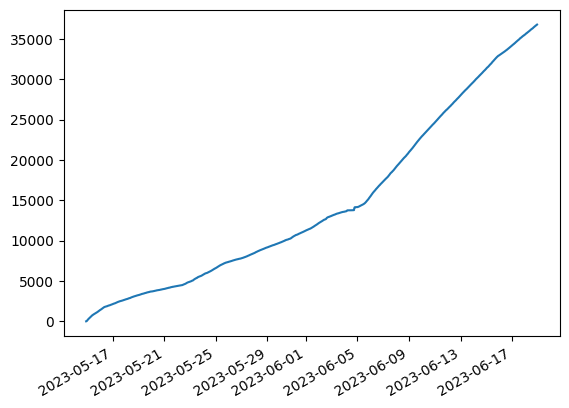

In [75]:
df['traveled_in_total'].plot()

In [110]:
def valve_behaviour(id,start,end):
    df = client.time_series.data.retrieve(id=id,start=start,end=end).to_pandas()
    df.columns = ['Prcent_opening']
    df['opening_cm'] = (df['Prcent_opening']/100)
    df['position_change'] = df['opening_cm'].diff()
    df = df[1:]
    df['abs_position_change'] = np.abs(df['position_change'].values)
    df['traveled_in_total'] = df['abs_position_change'].cumsum()
    df.index = (df.index.view(np.int64)-df.index.view(np.int64)[0])/(1e9*60*60)
    #df['traveled_in_total'].plot()
    return df['traveled_in_total']


In [111]:
#d=4146236330407219,start='6w-ago',end='now'
valve_behaviour(4146236330407219,datetime(2023,6,1),datetime(2023,6,7))

0.000000        0.000244
0.008333        0.000244
0.016667        0.000244
0.025000        0.000244
0.033333        0.000244
                 ...    
143.973017    188.007816
143.981350    188.007816
143.984129    188.008060
143.986907    188.043958
143.988299    188.044690
Name: traveled_in_total, Length: 32626, dtype: float64

In [112]:
dtn = datetime.now()

In [91]:
dtn

datetime.datetime(2023, 6, 26, 0, 47, 48, 15401)

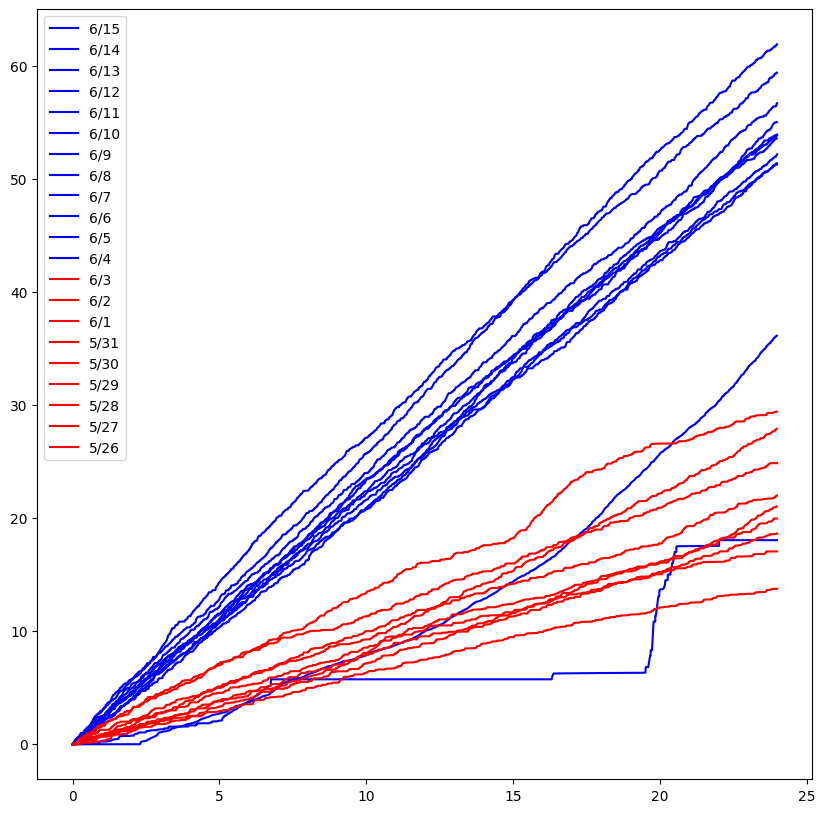

In [117]:
dtn = datetime.now()
start = datetime(dtn.year,dtn.month,dtn.day)

plt.figure(figsize=(10,10))
for i in range(10,31):
    values = valve_behaviour(4146236330407219,start-timedelta(days=i+1),start-timedelta(days=i))
    color = 'red'
    if(start-timedelta(days=i+1)>=datetime(2023,6,4)):
        color = 'blue'
    this_label = str((start-timedelta(days=i+1)).month)+'/'+str((start-timedelta(days=i+1)).day)
    plt.plot(values,color=color,label=this_label)
plt.legend()
plt.show()


In [120]:
def valve_diagnostic(id):
    dtn = datetime.now()
    start = datetime(dtn.year,dtn.month,dtn.day)

    plt.figure(figsize=(10,10))
    for i in range(10,31):
        values = valve_behaviour(id,start-timedelta(days=i+1),start-timedelta(days=i))
        color = 'red'
        if(start-timedelta(days=i+1)>=datetime(2023,6,4)):
            color = 'blue'
        this_label = str((start-timedelta(days=i+1)).month)+'/'+str((start-timedelta(days=i+1)).day)
        plt.plot(values,color=color,label=this_label)
    plt.legend()
    plt.show()

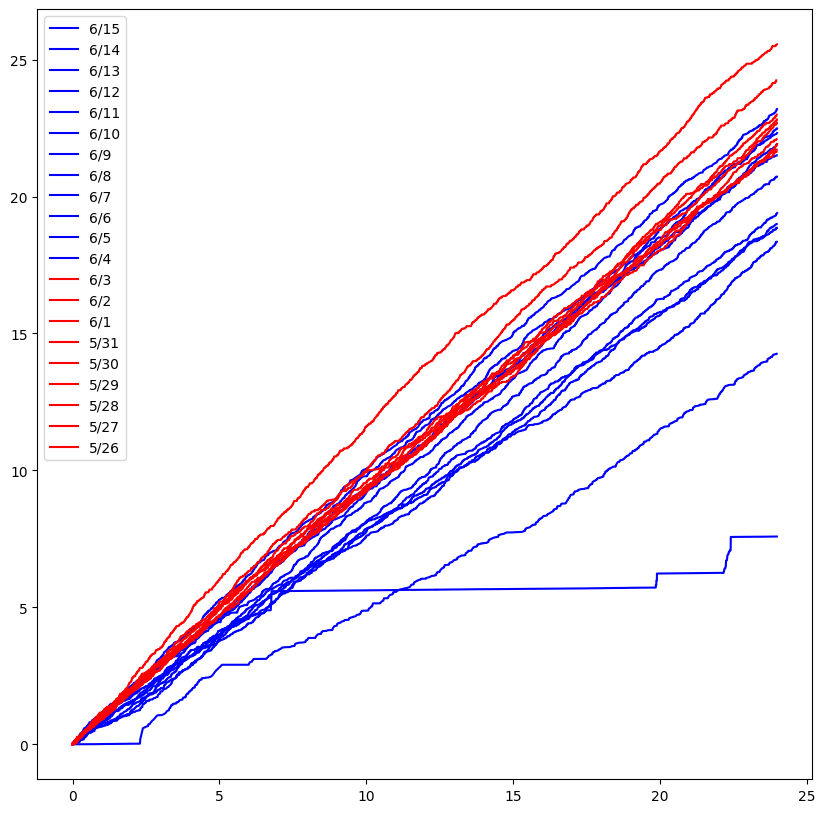

In [121]:
valve_diagnostic(3677162631471548)

In [126]:
client.time_series.search(name='PT')[6].id

3978413213546536

VAL_23-TT-92502:X.Value | PH 1stStgSuctCool Gas In


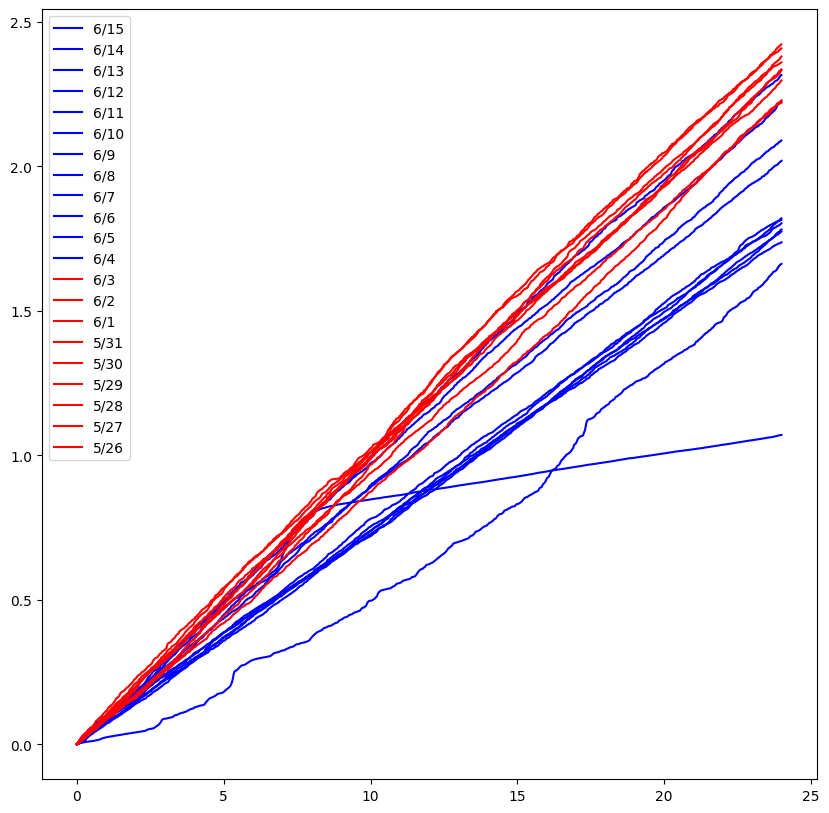

VAL_23-TT-92512:X.Value | PH 1stStgSuctCool Gas In


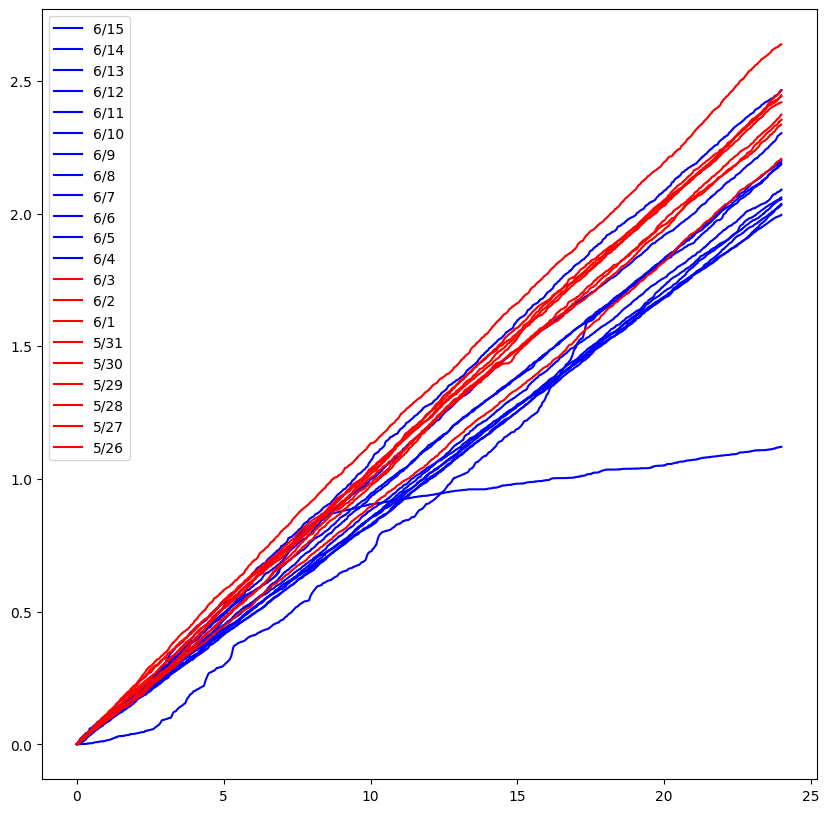

VAL_23-TT-92533:X.Value | PH 1stStgComp Suction


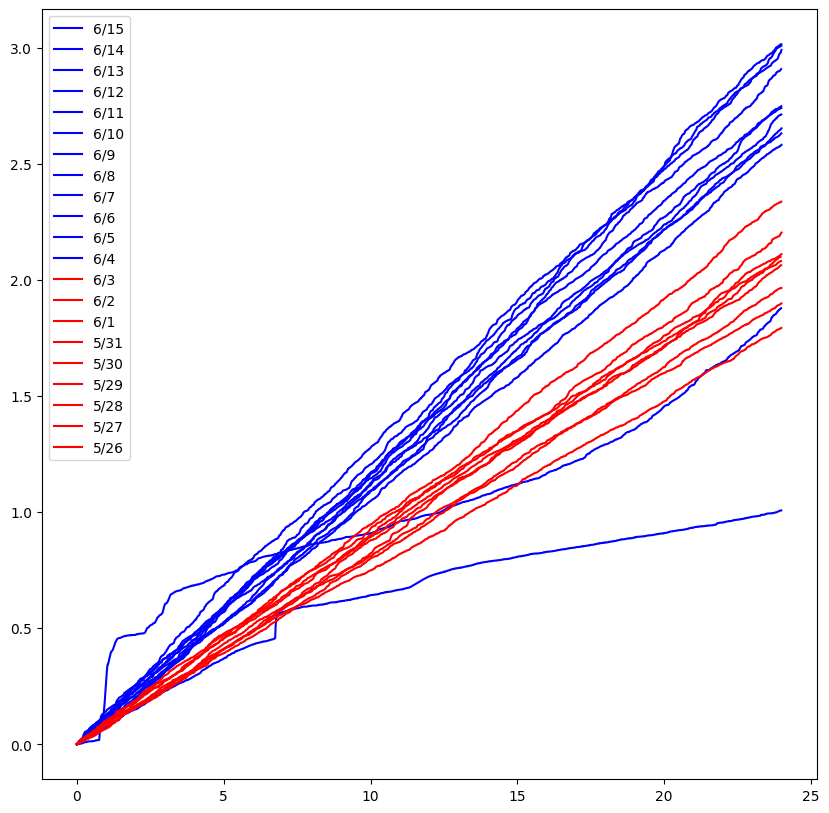

VAL_23-TT-92537:X.Value | PH 1stStgComp Discharge


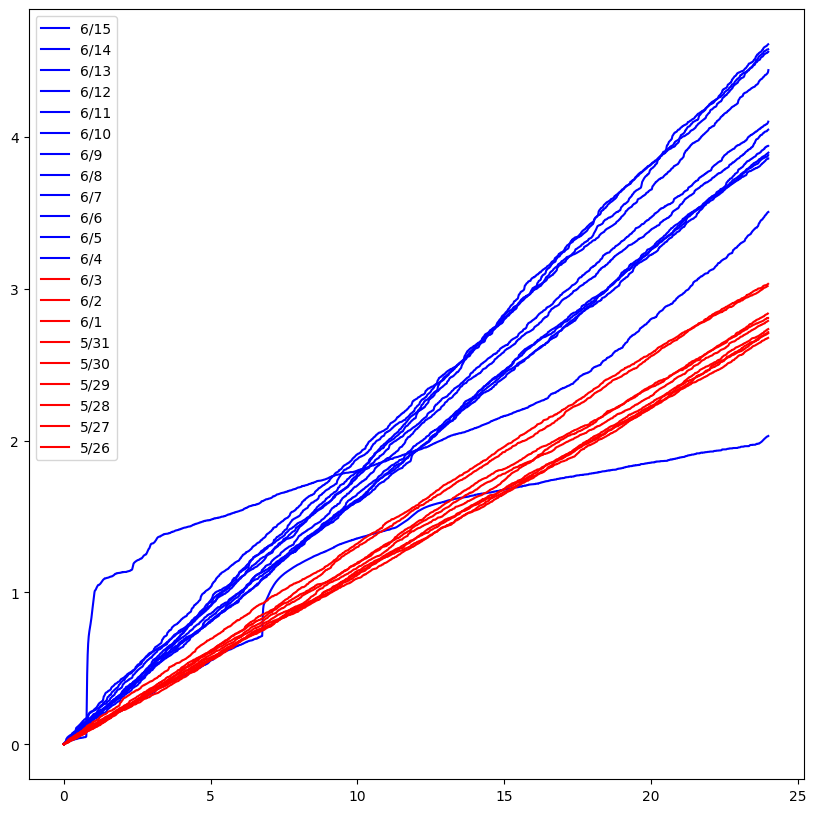

VAL_23-TT-92539:X.Value | PH 1stStgComp Discharge


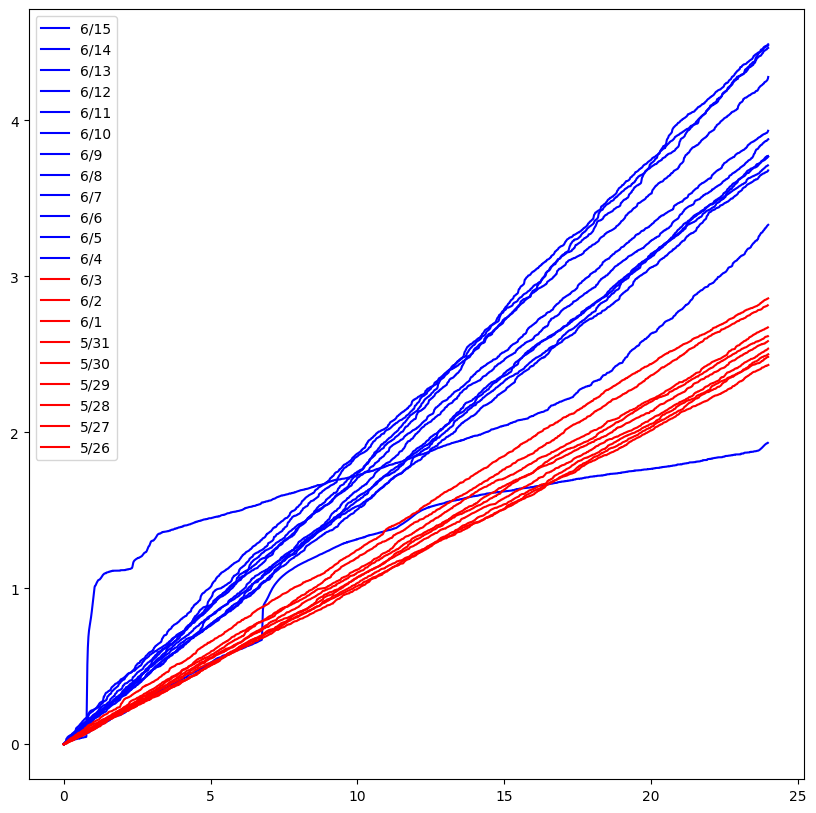

VAL_23-TT-92602:X.Value | PH 1stStgDiscCool Gas In


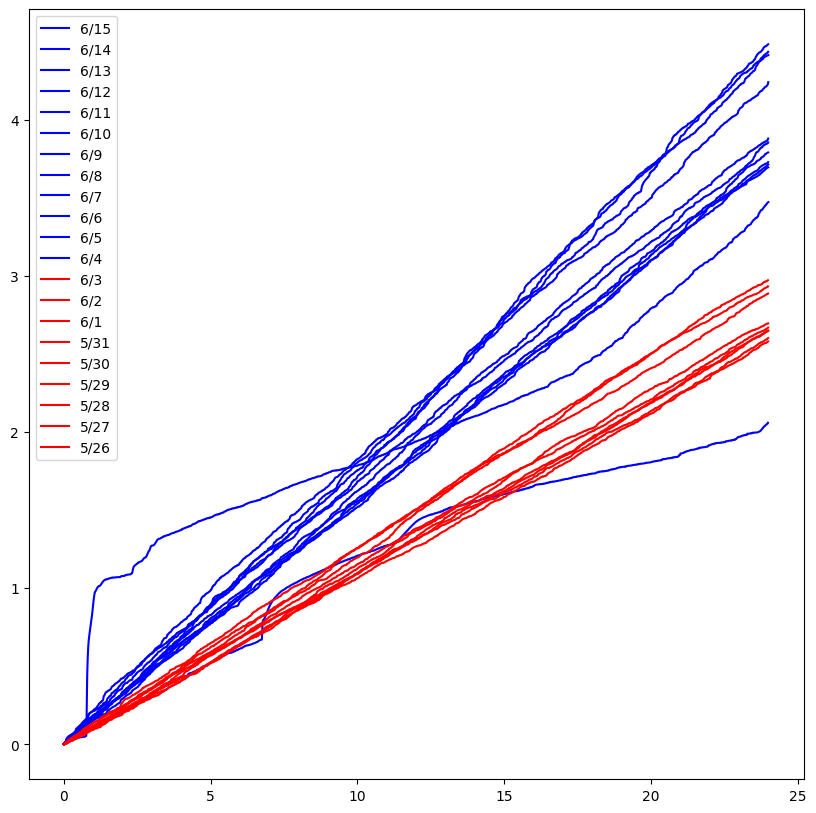

VAL_23-TT-92603:X.Value | PH 1stStgDiscCool Gas Out


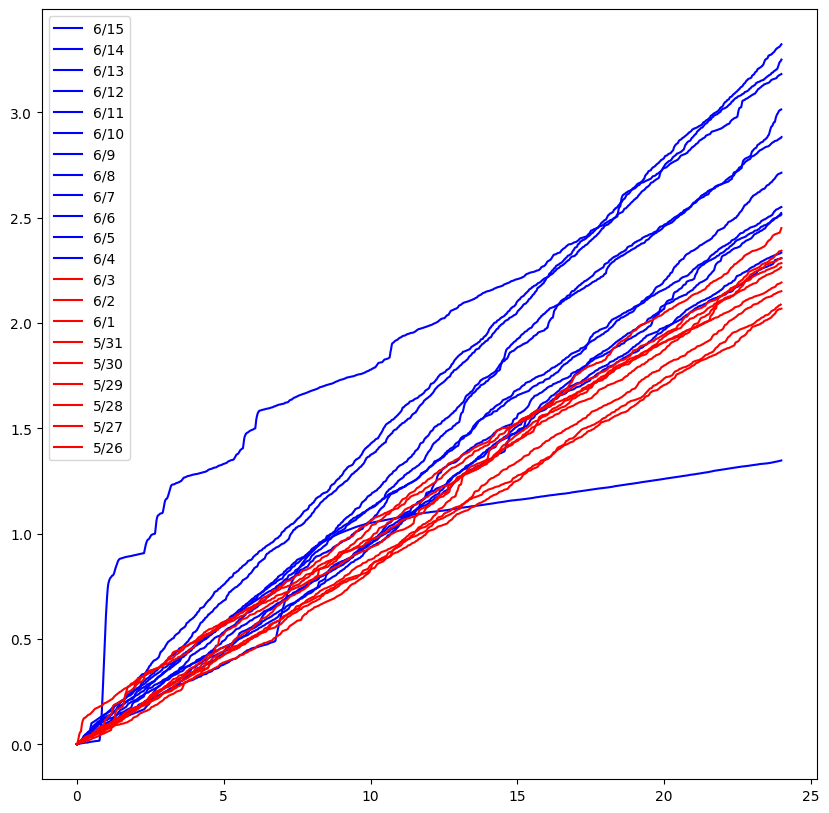

VAL_23-TT-92604A:X.Value | PH 1stStgDiscCool Gas Out Output


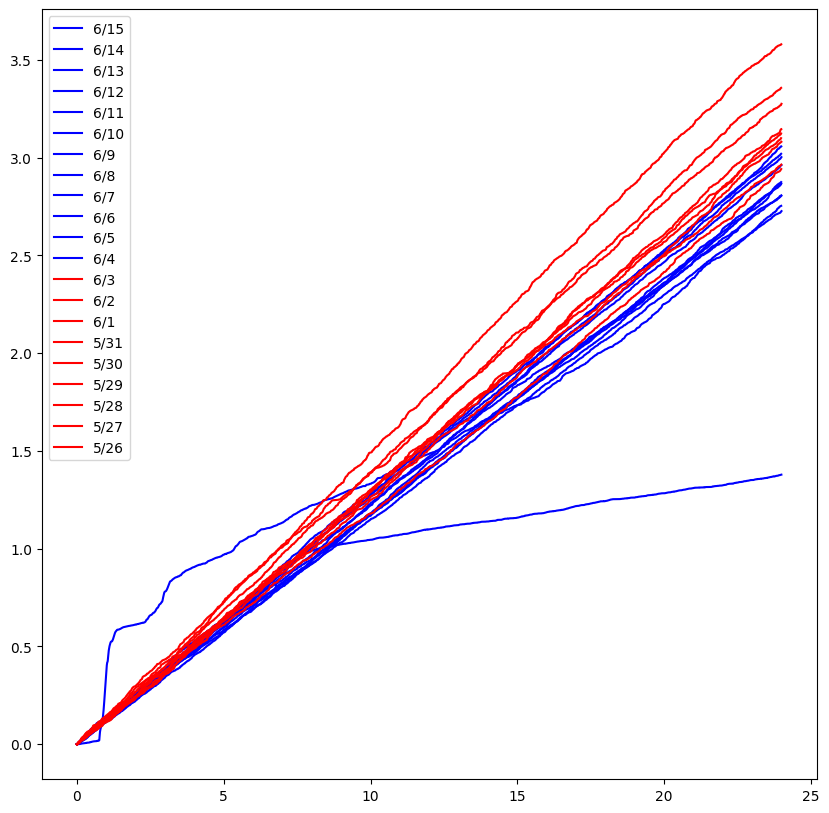

VAL_23-TT-96101-03:Z.X.Value | PH 1stStg Comp Journ BRG DE


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1000x1000 with 0 Axes>

In [129]:
for valve in client.time_series.search(name='TT'):
    print(valve.name + ' | ' + valve.description )
    valve_diagnostic(valve.id)